In [1]:
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import table

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Creating Precipitation Analysis pandas dataframe to house the "date" and "prcp" values from the "measurements" table
prcp_analysis_df = pd.read_sql("SELECT date, prcp FROM measurement", con=engine, columns=[["date"],["prcp"]])



In [9]:
# Converting the "date" field into the date data-type
prcp_analysis_df["date"] = pd.to_datetime(prcp_analysis_df["date"],format="%Y-%m-%d", errors="coerce")

In [10]:
# Determining the max date and subtracting 365 days to create the minimum date (or the past 12 months)
pa_max_date = prcp_analysis_df["date"].max().date()
pa_today = dt.date.today()
pa_min_date = (pa_max_date - dt.timedelta(days=365))
print("Date Range: "+str(pa_min_date)+" to "+str(pa_max_date))

Date Range: 2016-08-23 to 2017-08-23


In [11]:
# Dropping all records from Precipitation Analysis dataframe that are not within the last 12 months from the max date
prcp_analysis_df = prcp_analysis_df.loc[prcp_analysis_df["date"]>=pa_min_date]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [12]:
prcp_analysis_df.set_index("date", inplace=True)
prcp_analysis_df.describe(include="all")

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


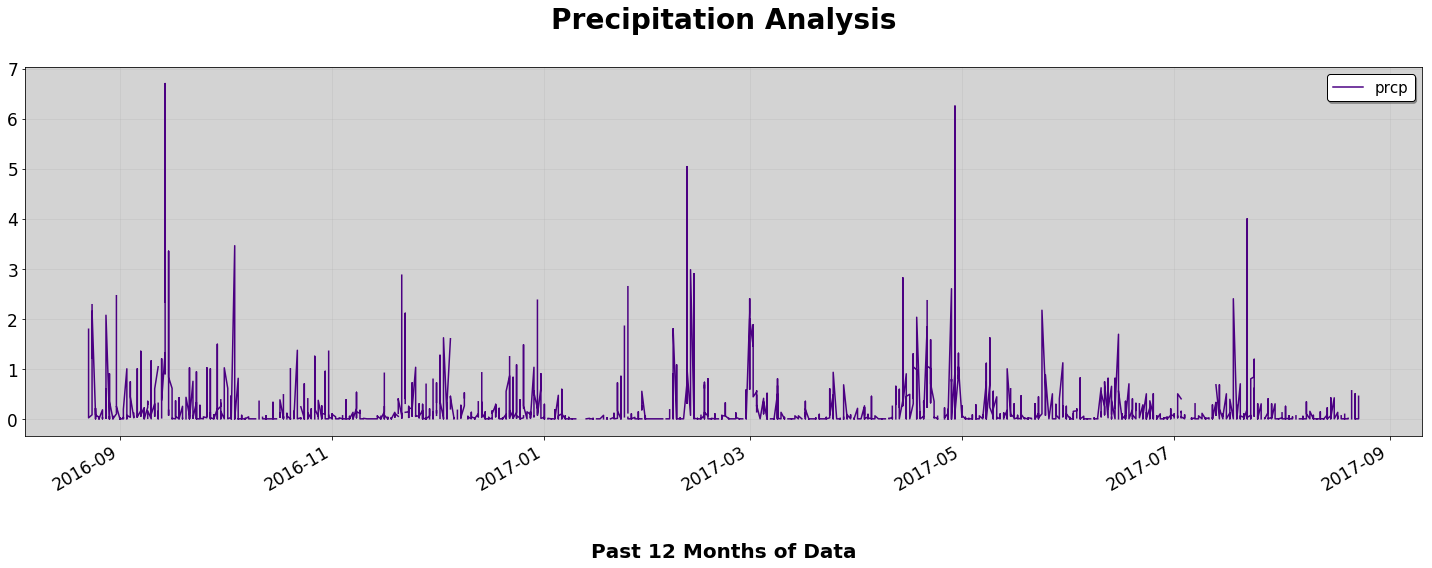

In [13]:
ax = prcp_analysis_df.plot.line(y="prcp",figsize=(20,8), fontsize=17, color="indigo")
ax.patch.set_facecolor("black")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="black", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("lightgray")
ax.grid(True, alpha=.3)
ax.legend(frameon=True, fancybox=True, facecolor="white", edgecolor="black", shadow=True, loc="best", fontsize=15, mode="exapnd")
ax.label_outer()
ax.set_title("Precipitation Analysis\n", fontsize=28, color="black", fontweight="bold")
plt.tight_layout()
plt.savefig("prcp_analysis.png")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_analysis_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    #filter(Measurement.station == 'USC00519281').all()

In [18]:
# Counting activity by station data to determine most active station
active_df = pd.read_sql("SELECT s.station, count(m.station) as station_count FROM measurement m,station s WHERE m.station=s.station GROUP BY m.station", con=engine, columns=[["station"],["station_count"]])


In [19]:
# Sorting the values by highest value count first
active_df.sort_values(by="station_count", ascending=False, inplace=True)


In [20]:
# Settings the "station" as the index
indexed_activity = active_df.set_index("station")



In [21]:
# Dataframe for most active staitons sorted by station count
indexed_activity


,station_count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [22]:
# Finding the highest value of the stations returned
max_activity = indexed_activity.station_count.max()

In [23]:
# Displaying the station name observation count of max_activity query
most_active = list(np.where(indexed_activity["station_count"]==max_activity)[0])
station_max = indexed_activity.iloc[most_active]
station_max =str(station_max.index[0])
print("Station with the most observations recorded: "+station_max+
      ", with a count of {:,} observations".format(max_activity))

Station with the most observations recorded: USC00519281, with a count of 2,772 observations


In [24]:
# Creating a query to database session to find all the "tobs" values from the "station_max" results for the past 12 months
sh_results = session.query(Measurement.date,Measurement.tobs).\
            filter(Measurement.date >= pa_min_date).\
            filter(Measurement.station==station_max).all()

In [25]:
# Converting the results of the query into a pandas dataframe
sh_max_df = pd.DataFrame(np.array(sh_results), columns=(["date","tobs"]))
sh_max_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [26]:
# Converting the data types so that the "tobs" column will return a value
sh_max_df.tobs = sh_max_df.tobs.astype(float)

In [27]:
# Verifying value types
sh_max_df.dtypes

date     object
tobs    float64
dtype: object

In [28]:
sh_max_df.describe(include="all")

,date,tobs
count,352,352.000000
unique,352,NaN
top,2016-11-08,NaN
freq,1,NaN
mean,NaN,73.107955
std,NaN,4.733315
min,NaN,59.000000
25%,NaN,70.000000
50%,NaN,74.000000
75%,NaN,77.000000


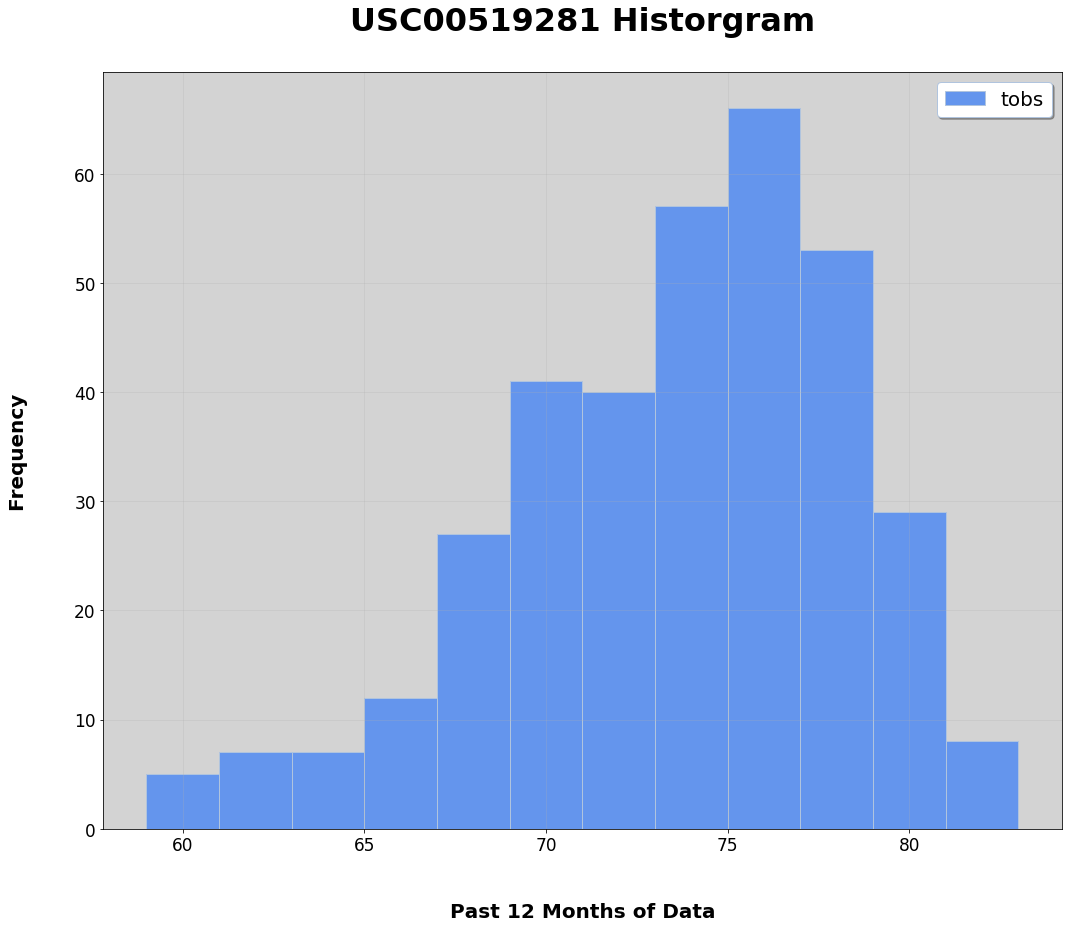

In [29]:
ax = sh_max_df.plot.hist(by=None, bins=12, figsize=(15, 13), color="cornflowerblue", fontsize=17, edgecolor="lightsteelblue")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="black", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("lightgray")
ax.grid(True, alpha=.3)
ax.set_ylabel(ylabel="Frequency\n\n", fontsize=20,fontweight="bold")
ax.legend(frameon=True, fancybox=True, facecolor="white", edgecolor="lightsteelblue", shadow=True, loc="best", fontsize=20, mode="exapnd")
ax.label_outer()
ax.set_title(str(station_max+" Historgram\n"), fontsize=32, color="black",fontweight="bold")
plt.tight_layout()
plt.savefig("tobs_histogram.png")

In [31]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:

        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


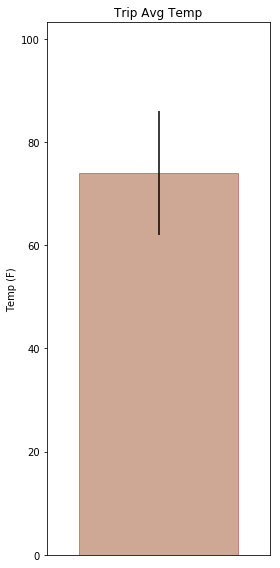

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='sienna', edgecolor='brown', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


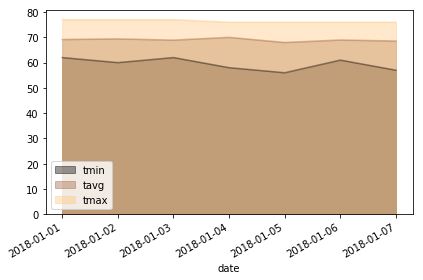

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.4, colormap='copper')
plt.tight_layout()
plt.show()